In [501]:
#importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import torch
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.neighbors import LocalOutlierFactor

# Plant X:
## -------------------------------------------------------------------------

In [ ]:
#importing the data from the excel file and chooses needed data
df_raw = pd.read_excel('plants_data.xlsx', sheet_name='Plant X', usecols='A:L', skiprows=1, nrows=1239)

# df_raw.drop(df_raw.columns[3], axis=1, inplace=True)
df_raw.drop(index=df_raw.index[0], inplace=True)

df_raw.head()

Date Feed B Feed S  Feed i  C1 RR%   C1  NGL RR%   NGL  Condensate RR  \
1 2021-01-01     99    407   106.0     1.0  645      1.0  2965            1.0   
2 2021-01-02    167    336   113.0     1.0  632      1.0  3316            1.0   
3 2021-01-03    176    418   118.0     1.0  640      1.0  3367            1.0   
4 2021-01-04    182    398   142.0     1.0  633      1.0  3500            1.0   
5 2021-01-05    186    455   142.0     1.0  622      1.0  3410            1.0   

  Condensate  Sulphur RR Sulphur  
1      15090         1.0    1390  
2      15541         1.0    1377  
3      14088         1.0    1384  
4      10628         1.0    1328  
5       9631         1.0    1299

In [503]:
df_raw

Date Feed B Feed S  Feed i  C1 RR%   C1  NGL RR%   NGL  \
1    2021-01-01     99    407   106.0     1.0  645      1.0  2965   
2    2021-01-02    167    336   113.0     1.0  632      1.0  3316   
3    2021-01-03    176    418   118.0     1.0  640      1.0  3367   
4    2021-01-04    182    398   142.0     1.0  633      1.0  3500   
5    2021-01-05    186    455   142.0     1.0  622      1.0  3410   
...         ...    ...    ...     ...     ...  ...      ...   ...   
1232 2024-05-16    278    486   136.0     1.0  640      1.0  3345   
1233 2024-05-17    280    422   116.0     1.0  641      1.0  3353   
1234 2024-05-18    298    446   147.0     1.0  627      1.0  3258   
1235 2024-05-19    288    453    87.0     1.0  641      1.0  3393   
1236 2024-05-20    286    439    86.0     1.0  643      1.0  3366   

      Condensate RR Condensate  Sulphur RR Sulphur  
1               1.0      15090         1.0    1390  
2               1.0      15541         1.0    1377  
3               1.0      14088         1.0    1384  
4               1.0      10628         1.0    1328  
5               1.0       9631         1.0    1299  
...             ...        ...         ...     ...  
1232            1.0      12871         1.0    1210  
1233            1.0      12535         1.0    1265  
1234            1.0      12070         1.0    1232  
1235            1.0      12612         1.0    1268  
1236            1.0      11609         1.0    1334  

[1236 rows x 12 columns]

In [504]:
df_raw.shape

(1236, 12)

In [ ]:
#since C1 RR is property of the plant not the feed, we will use the estimate potential of the feed
df_raw['C1'] = df_raw['C1']/df_raw['C1 RR']
df_raw['NGL'] = df_raw['NGL']/df_raw['NGL RR']
df_raw['Condensate'] = df_raw['Condensate']/df_raw['Condensate RR']
df_raw['Sulphur'] = df_raw['Sulphur']/df_raw['Sulphur RR']

In [506]:
#pre-processing function 1: remove 0 rows and outliers
def rm_zeros(df, columns):
    df_no_zeros = df[(df[columns] > 0).all(axis=1)].copy()
    return df_no_zeros

In [507]:
#pre-processing function 2: remove outliers
def rm_outliers(df, n_neighbors=20, contamination=0.01):
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    yhat = lof.fit_predict(df.select_dtypes(include=[np.number]))
    mask = yhat != -1
    df_clean = df[mask]
    
    return df_clean



In [508]:
#pre-processing function 2: normalising the data (uniform scale)
def uni_norm(df, numerical_cols, epsilon=1e-6):
    scaler = MinMaxScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols]) + epsilon

In [509]:
#utility function 1: printing dataFrame into file
def df_file_print(df, filename="df_values.txt"):
    with open(filename, 'w') as file:
        file.write(df.to_string(index=False))
    print(f"DataFrame values saved to {filename}")

In [510]:
#utility function 2: make 3D scatter plot for feeds + color it based on desiered output 
def make_graph(df, out, ins):
    selected_columns = ins + out
    df_selected = df[selected_columns]

    # Create a 3D scatter plot for each element in 'out'
    for val in out:
        fig = px.scatter_3d(
            df_selected,
            x=ins[0],
            y=ins[1],
            z=ins[2],
            color=val,
            color_continuous_scale='Viridis'
            ,title=f'3D Scatter Plot with {val} as Color'  
        )

        # Update layout
        fig.update_layout(
            scene=dict(
                xaxis_title=ins[0],
                yaxis_title=ins[1],
                zaxis_title=ins[2]
            ),

            width=600,
            height=600 
        )

        fig.show()

In [511]:
#utility function 3: make 2D scatter plot for 2 inputs feeds + color it based on desiered output (which is z)
def plot_2d(df, xyz):
    x = df[xyz[0]]
    y = df[xyz[1]]
    if xyz[2] != None:
        z = df[xyz[2]]
    else: z = xyz[2]
    
    plt.figure()
    scatter = plt.scatter(x, y, c=z, cmap='viridis')
    if xyz[2] != None:
        scatter = plt.scatter(x, y, c=z, cmap='viridis')
        plt.colorbar(scatter, label=xyz[2])
        title = "2D Scatter Plot with " +xyz[2]+ " as color (Third Dimension)"
    else:
        title = "2D Scatter Plot of"+xyz[1]+"vs"+xyz[0]
        scatter = plt.scatter(x, y)
    plt.xlabel(xyz[0])
    plt.ylabel(xyz[1])
    plt.title(title)
    plt.show()

In [512]:
#utility function 4: extract coeffiecnts and intercepts of Linear Regression model
def parameter_extractor(LinearModel,out):

    coefficients_list1 = []
    intercepts_list1 = []

    # Loop through each estimator in MultiOutputRegressor
    for estimator in LinearModel.estimators_:
        coefficients_list1.append(estimator.coef_)
        intercepts_list1.append(estimator.intercept_)

    input_columns1 = LinearModel.estimators_[0].feature_names_in_
    output_columns1 = out
    # Convert to DataFrames for easier readability
    coefficients_df = pd.DataFrame(coefficients_list1, columns=input_columns1, index=output_columns1)
    intercepts_series = pd.Series(intercepts_list1, index=output_columns1)
    
    return coefficients_df, intercepts_series

In [513]:
# utility function 5: train and test different models into desired inputs and outputs
def evaluate_models(df,out,cols):

    #cols are features we want as input
    X = df[cols]
    y = df[out]
    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

    # Initialize models
    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(),
        'Random Forest': RandomForestRegressor(),
        'Support Vector Regressor': SVR()
    }

    # Dictionary to store results
    results = {}
    trained_models = {}

    # Train and evaluate each model
    for model_name, model1 in models.items():
        model1 = MultiOutputRegressor(model1)

        model1.fit(X_train, y_train)
        y_pred = model1.predict(X_test)
        
        # Calculate metrics
        r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
        mse = mean_squared_error(y_test, y_pred, multioutput='uniform_average')
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred, multioutput='uniform_average')
        MAP = 1 - np.mean(np.abs((y_test - y_pred) / y_test))

        # Store results
        results[model_name] = {
            'R2 Score': r2,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'MAP': MAP,
        }
        trained_models[model_name] = model1
    # Convert results to DataFrame
    results_df = pd.DataFrame(results).T
    print('===================== Results for =====================')
    print(out)
    print(results_df,'\n')
    return trained_models ,results

In [514]:
# pre-processing the data
NumCols = ['Feed B', 'Feed S', 'Feed i', 'NGL', 'C1', 'Condensate', 'Sulphur']
df = df_raw.copy()
df = rm_zeros(df,NumCols)
df = rm_outliers(df, n_neighbors=10, contamination=0.05)
# NOTE: removeing outliers 1: only for output, 2: increase range
# uni_norm(df, NumCols)

In [515]:
df = df[['Feed B', 'Feed S', 'Feed i', 'C1', 'NGL', 'Condensate', 'Sulphur']]

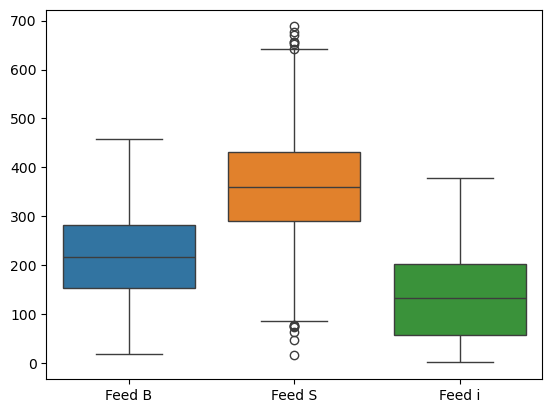

In [516]:
sns.boxplot(data=df[['Feed B', 'Feed S', 'Feed i']])
plt.show()

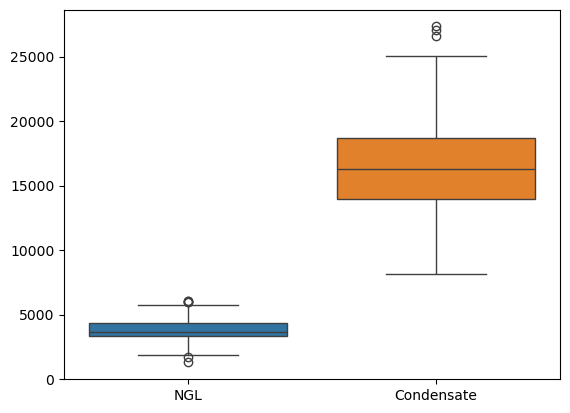

In [517]:
sns.boxplot(data=df[['NGL', 'Condensate']])
plt.show()

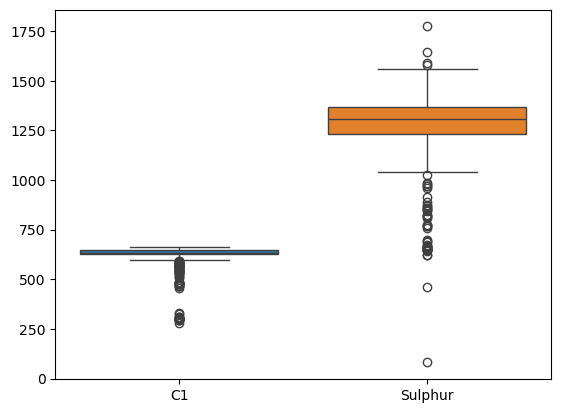

In [518]:
sns.boxplot(data=df[['C1','Sulphur']])
plt.show()

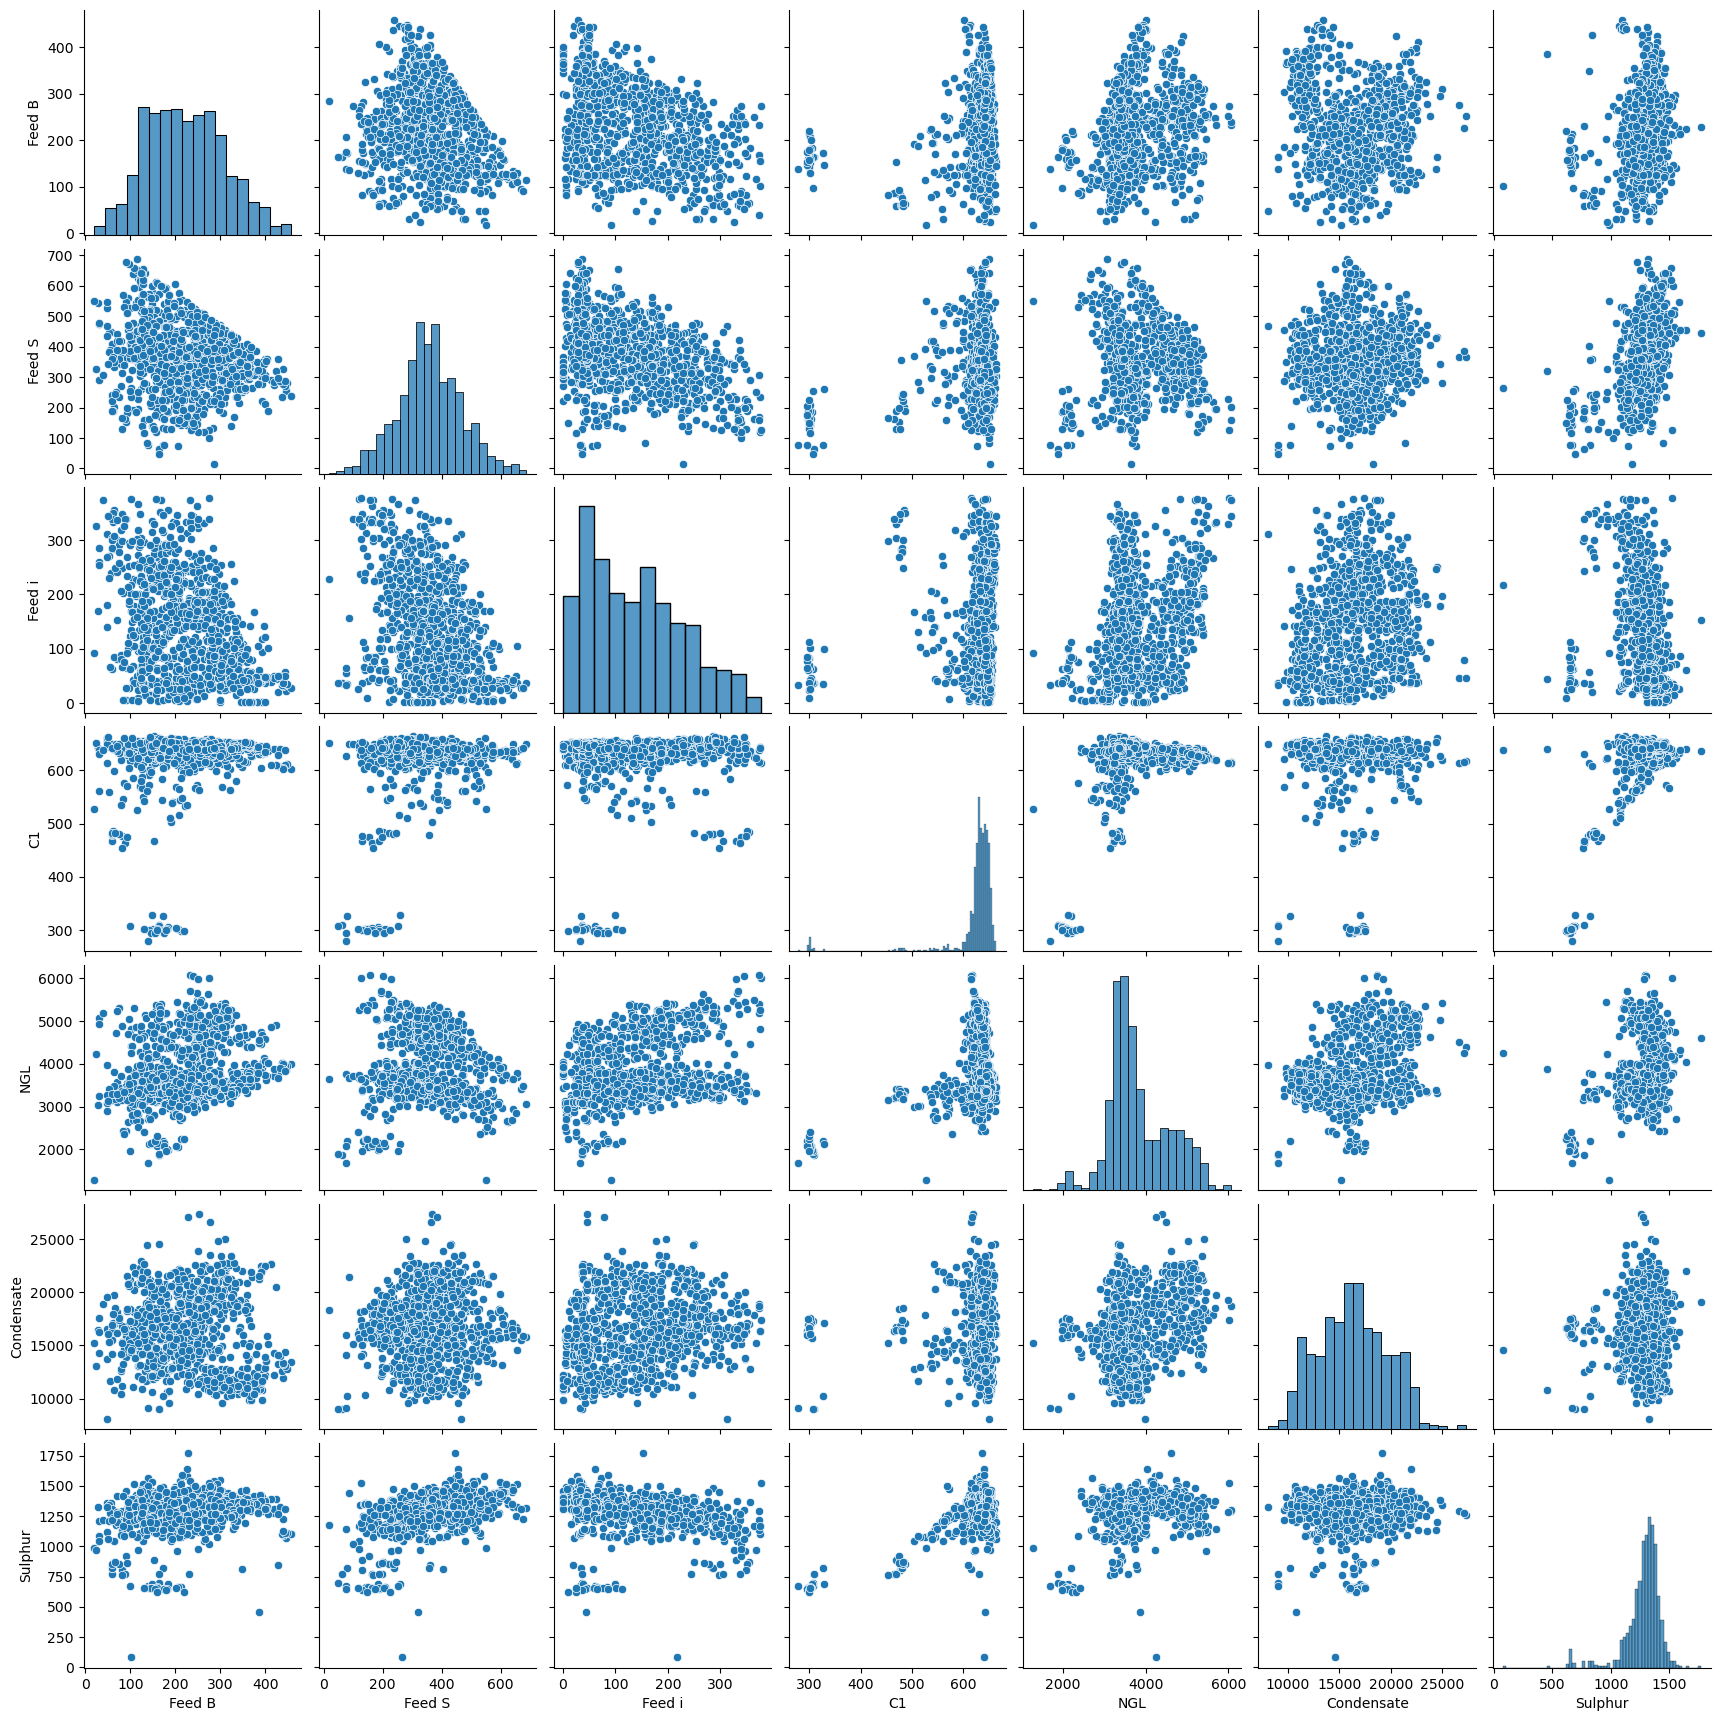

In [519]:
sns.pairplot(df)
plt.show()

In [520]:
df.head()

Feed B Feed S  Feed i     C1     NGL Condensate Sulphur
1     99    407   106.0  645.0  2965.0    15090.0  1390.0
2    167    336   113.0  632.0  3316.0    15541.0  1377.0
3    176    418   118.0  640.0  3367.0    14088.0  1384.0
4    182    398   142.0  633.0  3500.0    10628.0  1328.0
5    186    455   142.0  622.0  3410.0     9631.0  1299.0

In [521]:
df = df*1.0
val=['Feed B', 'Feed S', 'Feed i', 'C1', 'NGL', 'Condensate', 'Sulphur']
for i in val:
    df[i] = pd.to_numeric(df[i], errors='coerce')

In [522]:
correlation_matrix = df.corr(method='pearson')
correlation_matrix.head(7)

Feed B    Feed S    Feed i        C1       NGL  Condensate  \
Feed B      1.000000 -0.208419 -0.367674  0.165811  0.256431   -0.098620   
Feed S     -0.208419  1.000000 -0.391361  0.311641 -0.105986    0.074135   
Feed i     -0.367674 -0.391361  1.000000  0.088601  0.301325    0.206403   
C1          0.165811  0.311641  0.088601  1.000000  0.352464    0.007217   
NGL         0.256431 -0.105986  0.301325  0.352464  1.000000    0.343040   
Condensate -0.098620  0.074135  0.206403  0.007217  0.343040    1.000000   
Sulphur     0.209854  0.460366 -0.277381  0.678660  0.307330    0.017587   

             Sulphur  
Feed B      0.209854  
Feed S      0.460366  
Feed i     -0.277381  
C1          0.678660  
NGL         0.307330  
Condensate  0.017587  
Sulphur     1.000000

In [523]:
make_graph(df,['C1', 'NGL', 'Condensate', 'Sulphur'],['Feed B', 'Feed S', 'Feed i'])

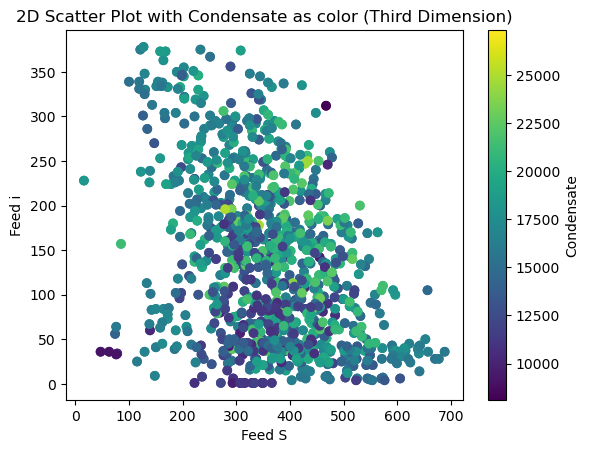

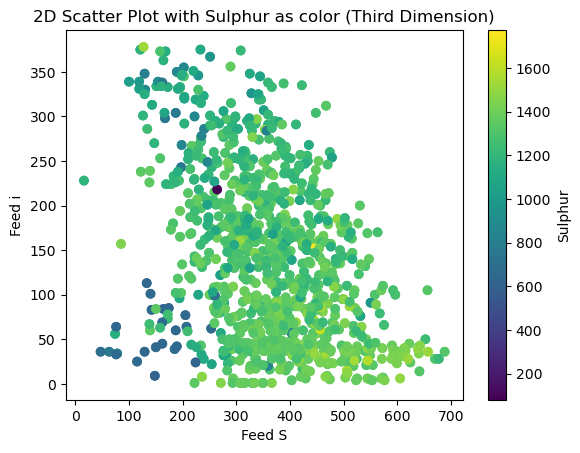

In [524]:
xyz =  ['Feed S', 'Feed i', 'Condensate']
plot_2d(df, xyz)
xyz =  ['Feed S', 'Feed i', 'Sulphur']
plot_2d(df, xyz)
# NOTE: use yields of plant x in Y

In [525]:
#evaluate different models on different with regard to differnet outcome
cols = ['Feed B', 'Feed S', 'Feed i']
C1_models , C1_results = evaluate_models(df,['C1'], cols)
NGL_models , NGL_results = evaluate_models(df,['NGL'], cols)
Condensate_models , Condensate_results = evaluate_models(df,['Condensate'], cols)
Sulphur_models , Sulphur_results = evaluate_models(df,['Sulphur'],cols)

===================== Results for =====================
['C1']
                          R2 Score          MSE       RMSE        MAE  \
Linear Regression         0.252319  2055.686968  45.339684  29.540222   
Decision Tree            -0.312246  3607.910448  60.065884  25.502488   
Random Forest             0.394051  1666.006469  40.816743  19.109917   
Support Vector Regressor  0.027026  2675.111101  51.721476  20.413380   

                               MAP  
Linear Regression         0.945723  
Decision Tree             0.952210  
Random Forest             0.965190  
Support Vector Regressor  0.955456   

===================== Results for =====================
['NGL']
                          R2 Score            MSE        RMSE         MAE  \
Linear Regression         0.334751  396248.921421  629.483059  556.459230   
Decision Tree             0.084452  545336.752163  738.469195  505.130222   
Random Forest             0.412867  349719.737454  591.371066  461.653532   
Support Vect

In [526]:
#evaluate different moels on different with regard to differnet outcome, using only feeds that are relevant

# cols = ['Feed B', 'Feed i', 'Feed S']
# C1_models = evaluate_models('C1', cols)

# cols = ['Feed B', 'Feed i', 'Feed S']
# NGL_models = evaluate_models('NGL', cols)

cols = ['Feed i', 'Feed S']
Condensate_models_reqFeed , Condensate_results_reqFeed = evaluate_models(df,['Condensate'], cols)

cols = ['Feed i', 'Feed S']
Sulphur_models_reqFeed , Sulphur_results_reqFeed = evaluate_models(df,['Sulphur'],cols)

===================== Results for =====================
['Condensate']
                          R2 Score           MSE         RMSE          MAE  \
Linear Regression         0.105371  1.038846e+07  3223.112983  2695.522513   
Decision Tree            -1.008930  2.332776e+07  4829.881526  3723.676617   
Random Forest            -0.007928  1.170409e+07  3421.123588  2696.955590   
Support Vector Regressor  0.000892  1.160168e+07  3406.123366  2819.143542   

                               MAP  
Linear Regression         0.828566  
Decision Tree             0.763089  
Random Forest             0.827339  
Support Vector Regressor  0.817822   

===================== Results for =====================
['Sulphur']
                          R2 Score           MSE        RMSE         MAE  \
Linear Regression         0.234746  15414.994511  124.157136   88.422713   
Decision Tree            -0.463272  29475.594527  171.684579  114.567164   
Random Forest             0.158517  16950.506315  130.1

In [527]:
cols = ['Feed B', 'Feed i', 'Feed S']
out = ['C1','NGL', 'Condensate', 'Sulphur']
all_models , all_results = evaluate_models(df,out,cols)

===================== Results for =====================
['C1', 'NGL', 'Condensate', 'Sulphur']
                          R2 Score           MSE         RMSE         MAE  \
Linear Regression         0.257110  2.680740e+06  1637.296547  838.231553   
Decision Tree            -0.127549  5.206349e+06  2281.742600  995.836848   
Random Forest             0.353742  2.506317e+06  1583.135092  733.738327   
Support Vector Regressor  0.026689  3.065391e+06  1750.825711  878.200152   

                               MAP  
Linear Regression         0.889622  
Decision Tree             0.883224  
Random Forest             0.907820  
Support Vector Regressor  0.887111   



In [528]:
cols = ['Feed B', 'Feed i', 'Feed S']
out = ['C1','NGL', 'Sulphur']
all_models_no_cond , all_results_no_cond = evaluate_models(df,out,cols)

===================== Results for =====================
['C1', 'NGL', 'Sulphur']
                          R2 Score            MSE        RMSE         MAE  \
Linear Regression         0.305470  137271.371544  370.501514  223.274638   
Decision Tree            -0.088802  189546.551244  435.369442  211.629577   
Random Forest             0.445390  121495.238159  348.561671  184.413758   
Support Vector Regressor  0.035506  217435.275535  466.299556  230.922866   

                               MAP  
Linear Regression         0.909814  
Decision Tree             0.913448  
Random Forest             0.929148  
Support Vector Regressor  0.910229   



In [529]:
coefficients, biases = parameter_extractor(all_models_no_cond['Linear Regression'],['C1','NGL', 'Sulphur'])

### NN functions

In [530]:
def prepare_data_kf(df, input_cols, output_cols):
    X = torch.tensor(df[input_cols].values, dtype=torch.float32)
    y = torch.tensor(df[output_cols].values, dtype=torch.float32).squeeze()

    return X, y

In [531]:
def prepare_data(df, input_cols, output_cols, test_size=0.2, random_state=7):
    X = df[input_cols].values.astype(np.float32)
    y = df[output_cols].values.astype(np.float32)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Convert to tensors
    X_train = torch.tensor(X_train)
    y_train = torch.tensor(y_train)
    X_test = torch.tensor(X_test)
    y_test = torch.tensor(y_test)
    
    return X_train, X_test, y_train, y_test

In [532]:
# one minus Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_pred, y_true):
    return 100-torch.mean(torch.abs((y_true - y_pred) / y_true)) * 100

# R-squared (R2)
def r2_score_nn(y_pred, y_true):
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

In [533]:
def loss_plot(train_loss_values, test_loss_values, start = 0, end= None):
    if end == None:
        end = len(train_loss_values)
    plt.figure(figsize=(10, 6))
    plt.plot(range(start,end), train_loss_values[start:end], label='Training Loss')
    plt.plot(range(start,end), test_loss_values[start:end], label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Test Loss vs. Epochs')
    plt.legend()
    plt.show()

In [534]:
#Feed Forward NN Class
class FeedForwardNN(nn.Module):
    def __init__(self, input, hidden_sizes, output, df , coefficients, biases, lr):
        super(FeedForwardNN, self).__init__()

        self.input = input
        self.output = output
        self.hidden_sizes = hidden_sizes
        self.df = df
        self.coefficients = coefficients
        self.biases = biases
        self.lr = lr

        # list of hidden layers
        layers = []
        layers.append(nn.Linear(len(input), hidden_sizes[0]))    # <-- input layer

        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        
        layers.append(nn.Linear(hidden_sizes[-1], len(output)))     # <-- output layer
        
        self.layers = nn.ModuleList(layers)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.leaky_relu(layer(x))
            
        x = self.layers[-1](x)
        
        return x

#function to create NN model of FFNN
def makeNN(input, output,hidden_sizes, df, coefficients=pd.DataFrame([]), biases=pd.DataFrame([]), lr=0.001):
    model = FeedForwardNN(input, hidden_sizes, output, df, coefficients, biases, lr)
    
    if not ((coefficients.empty) and (biases.empty)):
        with torch.no_grad():
            # Access the first layer
            first_layer = model.layers[0]
            
            # Initialize weights and biases of the first layer only
            first_layer.weight.copy_(torch.tensor(coefficients.values, dtype=torch.float32))
            first_layer.bias.copy_(torch.tensor(biases.values, dtype=torch.float32))
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    return model, criterion, optimizer 
    

def trainKfolds(model,criterion, optimizer, n_splits=5, shuffle=True, random_state=7, epochs=1000, freq = 0.01, printOut =1):
    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    
    X, y = prepare_data_kf(model.df, model.input, model.output)
    fold_results = []

    models = []
    all_train_losses = []
    all_val_losses = []
    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        model, criterion, optimizer = makeNN(model.input, model.output, model.hidden_sizes, model.df, coefficients=model.coefficients, biases=model.biases, lr=model.lr)
        print(f'\nFold {fold + 1}/{n_splits}')

        #split data
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        train_loss_values, val_loss_values = train(
            model, criterion, optimizer, X_train, y_train, X_val, y_val,
            epochs=epochs, freq=freq, printOut=printOut
        )

        models.append(model)
        all_train_losses.append(train_loss_values)
        all_val_losses.append(val_loss_values)

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val).squeeze()
            val_loss = criterion(val_outputs, y_val).item()
            mape = mean_absolute_percentage_error(val_outputs, y_val)
            r2 = r2_score_nn(val_outputs, y_val)

        print(f'Fold {fold + 1} Validation Loss: {val_loss:.4f}, MAPE: {mape.item():.2f}%, R²: {r2.item():.4f}')

        fold_results.append({
            'fold': fold + 1,
            'val_loss': val_loss,
            'MAPE': mape.item(),
            'R²': r2.item()
        })
    
    avg_train_losses = np.mean(all_train_losses, axis=0)
    avg_val_losses = np.mean(all_val_losses, axis=0)

    # Compute average metrics
    avg_val_loss = np.mean([res['val_loss'] for res in fold_results])
    avg_mape = np.mean([res['MAPE'] for res in fold_results])
    avg_r2 = np.mean([res['R²'] for res in fold_results])

    print(f'\nAverage Validation Loss: {avg_val_loss:.4f}, Average MAPE: {avg_mape:.2f}%, Average R²: {avg_r2:.4f}')
    return models, fold_results, avg_train_losses, avg_val_losses


# function to train nn model
def train(model,criterion, optimizer, X_train, y_train, X_val, y_val, epochs=1000, freq = 0.01, printOut =1):
    train_loss_values = []
    val_loss_values = []
    
    for epoch in range(epochs):
        model.train()
        
        # Forward pass on training data
        outputs = model(X_train).squeeze()
        train_loss_nn = criterion(outputs, y_train)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        train_loss_nn.backward()
        optimizer.step()
        
        # Save training loss for plotting
        train_loss_values.append(train_loss_nn.item())
        
        # Calculate and save val loss every epoch
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val).squeeze()
            val_loss_nn = criterion(val_outputs, y_val)
            val_loss_values.append(val_loss_nn.item())

            # Print loss (epochs*freq) times
            if (epoch + 1) % int(epochs * freq) == 0:
                mape_nn = mean_absolute_percentage_error(val_outputs, y_val)
                r2_nn = r2_score_nn(val_outputs, y_val)
                if printOut:
                    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss_nn.item():.4f}, '
                          f'Validation Loss: {val_loss_nn.item():.4f}, MAPE: {mape_nn.item():.2f}%, '
                          f'R²: {r2_nn.item():.4f}')


    return train_loss_values, val_loss_values

def predict(model, X):
    model.eval()
    with torch.no_grad():
        predictions = model(X)
    predictions = predictions.numpy()
    return predictions

def ensemble_predict(models, X):
    predictions = []
    for model in models:
        model.eval()
        with torch.no_grad():
            pred = model(X).numpy()
            predictions.append(pred)
    avg_prediction = np.mean(predictions, axis=0)
    return avg_prediction

In [535]:
def feedsYield (nnModel, cols, rows, multipleModels = 0, constExp = [0,1000,2], feedRangeBounds = [0,2000]):
    
    start, end ,step = constExp
    feedL, feedR = feedRangeBounds
    var_col = np.arange(feedL,feedR,(feedR-feedL)/((end-start)/step))
    
    yield_results = np.full(len(cols), -1)
    yield_std = np.full(len(cols), -1)

    
    for r in np.arange(0,len(rows)):
        
        all_feeds_yield = np.array([])
        all_feeds_yield_std = np.array([])

        for i in np.arange(0,len(cols)):
            single_feed_yields_list = np.array([])

            for j in np.arange(start,end,step):
                temp = []
                const_col = np.full((int)((end-start)/step), j)

                temp = np.column_stack([const_col] * len(cols))
                temp[:, i] = var_col
                newTestData = torch.tensor(temp, dtype=torch.float32)

                if multipleModels:
                    predictions = ensemble_predict(nnModel,newTestData)
                else:
                    predictions = predict(nnModel, newTestData)
                
                # predictions = yield * amount of changing Feed + constant wheight added from other feeds
                #  y= m * x + b
                b = predictions[0,r]
                
                single_feed_single_value_yield_list = (predictions[1:,r]-b)/var_col[1:]
                mean_single_feed_single_value_yield = np.mean(single_feed_single_value_yield_list)
                single_feed_yields_list = np.append(single_feed_yields_list , mean_single_feed_single_value_yield)

            single_feed_yield = np.mean(single_feed_yields_list)
            single_feed_yield_std = np.std(single_feed_yields_list)

            all_feeds_yield = np.append(all_feeds_yield, single_feed_yield)
            all_feeds_yield_std = np.append(all_feeds_yield_std, single_feed_yield_std)

        yield_results = np.vstack((yield_results, all_feeds_yield))
        yield_std = np.vstack((yield_std, all_feeds_yield_std))
        
    yield_results = yield_results[1:,:]
    yield_std = yield_std[1:,:]

    yield_results = pd.DataFrame(yield_results, columns=cols, index=rows)
    yield_std = pd.DataFrame(yield_std, columns=cols, index=rows)

    return yield_results, yield_std


Fold 1/5
Epoch [10/1000], Training Loss: 73150456.0000, Validation Loss: 74927920.0000, MAPE: 0.43%, R²: -0.6948
Epoch [20/1000], Training Loss: 72992640.0000, Validation Loss: 74763776.0000, MAPE: 0.94%, R²: -0.6911
Epoch [30/1000], Training Loss: 72815712.0000, Validation Loss: 74578824.0000, MAPE: 1.54%, R²: -0.6869
Epoch [40/1000], Training Loss: 72607976.0000, Validation Loss: 74361200.0000, MAPE: 2.31%, R²: -0.6820
Epoch [50/1000], Training Loss: 72353208.0000, Validation Loss: 74094720.0000, MAPE: 3.31%, R²: -0.6759
Epoch [60/1000], Training Loss: 72030688.0000, Validation Loss: 73757328.0000, MAPE: 4.66%, R²: -0.6683
Epoch [70/1000], Training Loss: 71623288.0000, Validation Loss: 73332120.0000, MAPE: 6.44%, R²: -0.6587
Epoch [80/1000], Training Loss: 71111888.0000, Validation Loss: 72798752.0000, MAPE: 8.75%, R²: -0.6466
Epoch [90/1000], Training Loss: 70470600.0000, Validation Loss: 72129736.0000, MAPE: 11.75%, R²: -0.6315
Epoch [100/1000], Training Loss: 69668944.0000, Valid

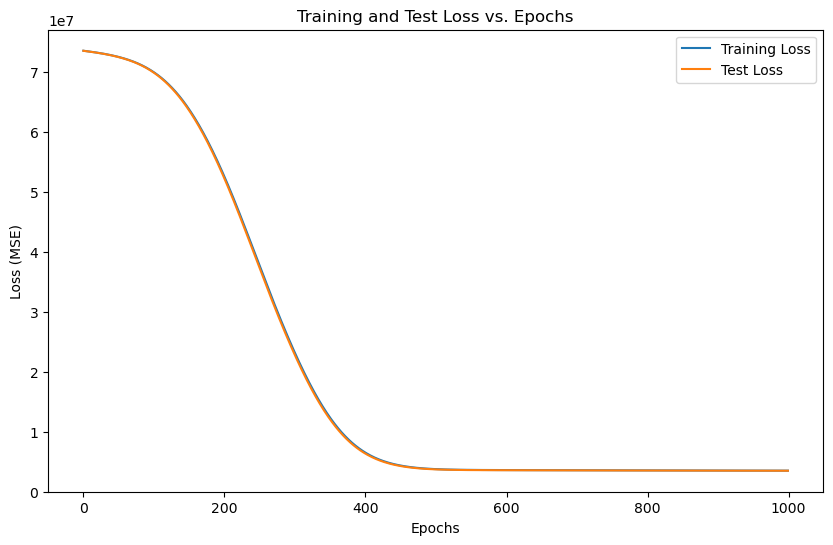

In [536]:
# NOTE: weight of internsically higherr value feed on loss, try normalization
input = [ 'Feed B','Feed S', 'Feed i']
output = ['NGL', 'C1', 'Condensate', 'Sulphur']
hidden_sizes = [12,12]

fnn, criterion, optimizer = makeNN(input, output, hidden_sizes, df)
models, fold_results, trainLoss, valLoss = trainKfolds(fnn, criterion, optimizer, epochs=1000, n_splits=5)
loss_plot(trainLoss, valLoss)


Fold 1/5
Epoch [10/1000], Training Loss: 5631956.0000, Validation Loss: 5750385.5000, MAPE: -0.89%, R²: -1.6977
Epoch [20/1000], Training Loss: 5601830.5000, Validation Loss: 5719142.0000, MAPE: -0.73%, R²: -1.6831
Epoch [30/1000], Training Loss: 5568102.0000, Validation Loss: 5683794.0000, MAPE: -0.49%, R²: -1.6665
Epoch [40/1000], Training Loss: 5527401.5000, Validation Loss: 5640719.0000, MAPE: -0.11%, R²: -1.6463
Epoch [50/1000], Training Loss: 5476022.0000, Validation Loss: 5586335.0000, MAPE: 0.44%, R²: -1.6208
Epoch [60/1000], Training Loss: 5410380.0000, Validation Loss: 5517134.0000, MAPE: 1.20%, R²: -1.5883
Epoch [70/1000], Training Loss: 5325726.0000, Validation Loss: 5428025.5000, MAPE: 2.23%, R²: -1.5465
Epoch [80/1000], Training Loss: 5214399.0000, Validation Loss: 5310247.5000, MAPE: 3.61%, R²: -1.4913
Epoch [90/1000], Training Loss: 5065890.0000, Validation Loss: 5153700.5000, MAPE: 5.47%, R²: -1.4178
Epoch [100/1000], Training Loss: 4878443.5000, Validation Loss: 4957

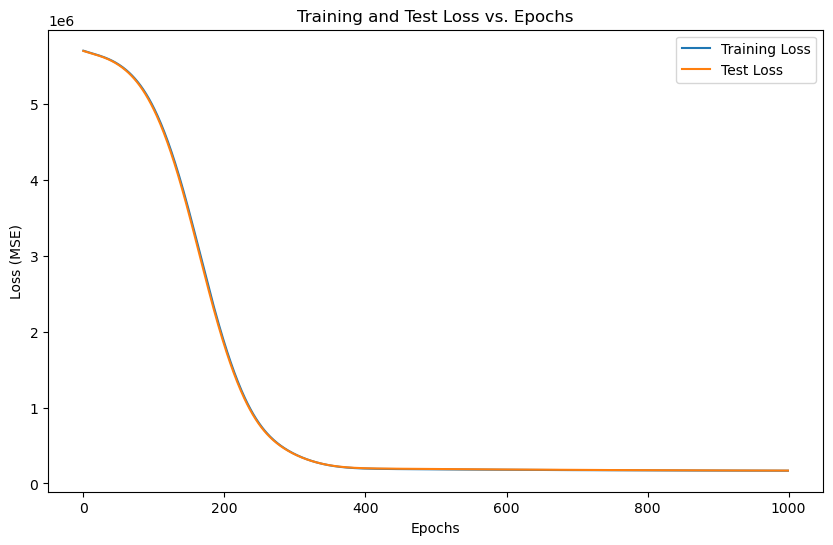

In [537]:
input = [ 'Feed B','Feed S', 'Feed i']
output = ['NGL', 'C1', 'Sulphur']
hidden_sizes = [12,12]

fnn, criterion, optimizer = makeNN(input, output, hidden_sizes, df)
models, fold_results, trainLoss, valLoss = trainKfolds(fnn, criterion, optimizer, epochs=1000, n_splits=5)
loss_plot(trainLoss, valLoss)


Fold 1/5
Epoch [10/1000], Training Loss: 5484074.5000, Validation Loss: 5553789.0000, MAPE: -13.36%, R²: -1.6055
Epoch [20/1000], Training Loss: 4997526.5000, Validation Loss: 5058343.5000, MAPE: -9.49%, R²: -1.3731
Epoch [30/1000], Training Loss: 4481940.5000, Validation Loss: 4525111.0000, MAPE: -5.29%, R²: -1.1229
Epoch [40/1000], Training Loss: 3869701.5000, Validation Loss: 3893996.5000, MAPE: 1.97%, R²: -0.8268
Epoch [50/1000], Training Loss: 3195299.7500, Validation Loss: 3203395.5000, MAPE: 12.12%, R²: -0.5028
Epoch [60/1000], Training Loss: 2496383.0000, Validation Loss: 2491997.5000, MAPE: 25.15%, R²: -0.1691
Epoch [70/1000], Training Loss: 1822542.5000, Validation Loss: 1811478.8750, MAPE: 40.68%, R²: 0.1502
Epoch [80/1000], Training Loss: 1234072.7500, Validation Loss: 1224037.0000, MAPE: 57.03%, R²: 0.4258
Epoch [90/1000], Training Loss: 785211.0000, Validation Loss: 780634.6875, MAPE: 69.22%, R²: 0.6338
Epoch [100/1000], Training Loss: 482322.8750, Validation Loss: 48476

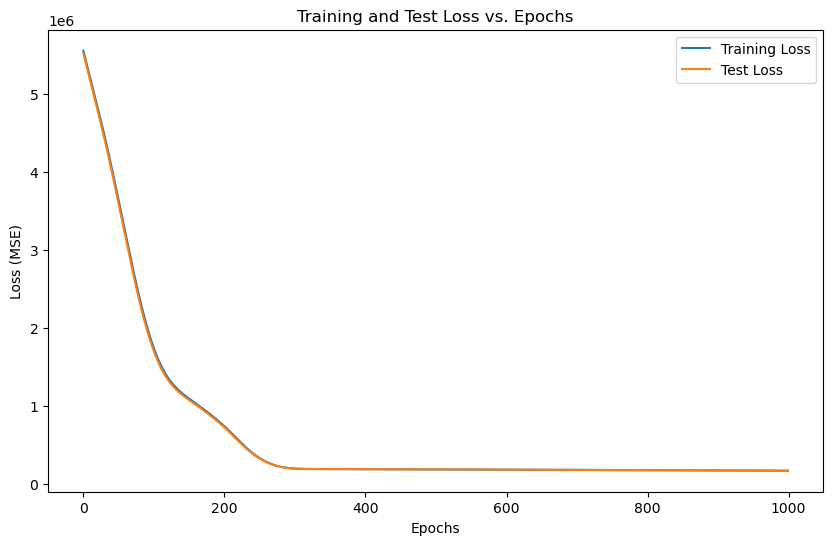

In [538]:
input = [ 'Feed B','Feed S', 'Feed i']
output = ['NGL', 'C1', 'Sulphur']
hidden_sizes = [3,9,12]

fnn, criterion, optimizer = makeNN(input, output, hidden_sizes, df,coefficients = coefficients, biases= biases)

models, fold_results, trainLoss, valLoss = trainKfolds(fnn, criterion, optimizer, epochs=1000, n_splits=5)
loss_plot(trainLoss, valLoss)

In [539]:
input = [ 'Feed B','Feed S', 'Feed i']
output = ['NGL', 'C1', 'Condensate', 'Sulphur']

Dlosses_train = []
Dlosses_test = []
for d in np.arange(2, 20):    
    hidden_sizes = np.full(d, 4)

    fnn, criterion, optimizer = makeNN(input, output, hidden_sizes,df)
    models, fold_results, trainLoss, valLoss = trainKfolds(fnn, criterion, optimizer, epochs=1000, n_splits=5, printOut=0)

    Dlosses_train.append(np.mean(trainLoss[-10:]))
    Dlosses_test.append(np.mean(valLoss[-10:])) 

Wlosses_train = []
Wlosses_test = []
for w in np.arange(2, 20):    
    hidden_sizes = np.full(4, w)

    fnn, criterion, optimizer = makeNN(input, output, hidden_sizes,df)
    models, fold_results, trainLoss, valLoss = trainKfolds(fnn, criterion, optimizer, epochs=1000, n_splits=5, printOut=0)

    Wlosses_train.append(np.mean(trainLoss[-10:]))
    Wlosses_test.append(np.mean(valLoss[-10:]))


Fold 1/5
Fold 1 Validation Loss: 3852201.5000, MAPE: 85.83%, R²: 0.9129

Fold 2/5
Fold 2 Validation Loss: 4263041.5000, MAPE: 85.25%, R²: 0.9011

Fold 3/5
Fold 3 Validation Loss: 3279572.0000, MAPE: 84.99%, R²: 0.9205

Fold 4/5
Fold 4 Validation Loss: 3492923.2500, MAPE: 85.96%, R²: 0.9191

Fold 5/5
Fold 5 Validation Loss: 8418097.0000, MAPE: 81.35%, R²: 0.8121

Average Validation Loss: 4661167.0500, Average MAPE: 84.67%, Average R²: 0.8931

Fold 1/5
Fold 1 Validation Loss: 3098892.5000, MAPE: 86.17%, R²: 0.9299

Fold 2/5
Fold 2 Validation Loss: 4214358.5000, MAPE: 85.84%, R²: 0.9022

Fold 3/5
Fold 3 Validation Loss: 3207374.2500, MAPE: 85.65%, R²: 0.9222

Fold 4/5
Fold 4 Validation Loss: 3938304.0000, MAPE: 85.64%, R²: 0.9088

Fold 5/5
Fold 5 Validation Loss: 3755615.2500, MAPE: 85.10%, R²: 0.9162

Average Validation Loss: 3642908.9000, Average MAPE: 85.68%, Average R²: 0.9159

Fold 1/5
Fold 1 Validation Loss: 3432351.2500, MAPE: 85.04%, R²: 0.9224

Fold 2/5
Fold 2 Validation Loss: 7

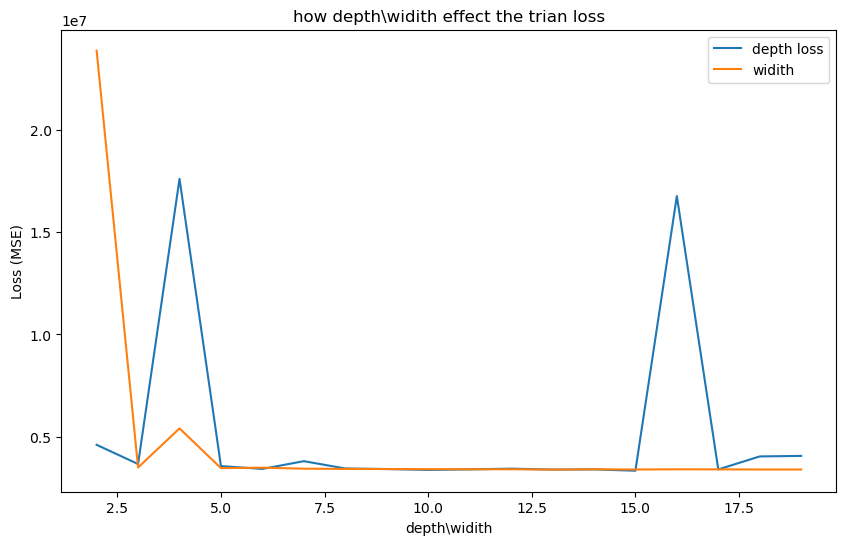

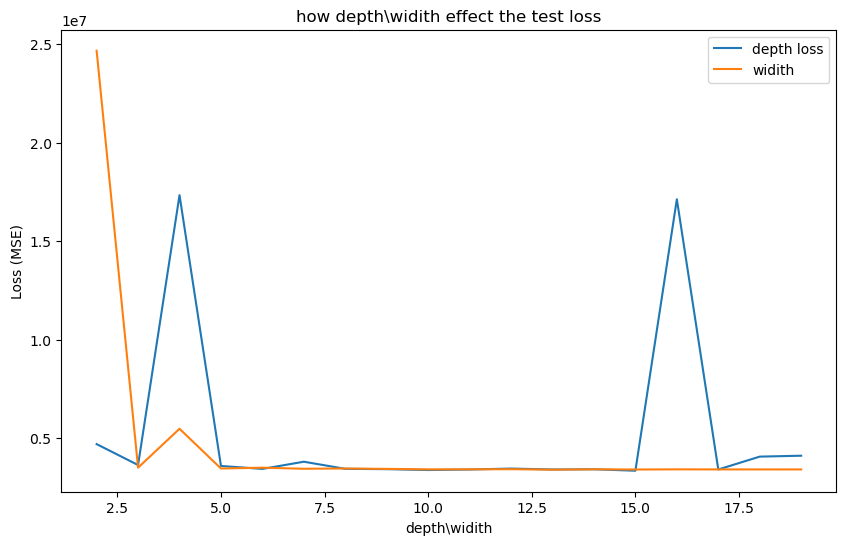

In [540]:
start = 0
plt.figure(figsize=(10, 6))
plt.plot(range(2+start,20), Dlosses_train[start:], label='depth loss')
plt.plot(range(2+start,20), Wlosses_train[start:], label='widith')
plt.xlabel('depth\\widith')
plt.ylabel('Loss (MSE)')
plt.title('how depth\\widith effect the trian loss')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(range(2+start,20), Dlosses_test[start:], label='depth loss')
plt.plot(range(2+start,20), Wlosses_test[start:], label='widith')
plt.xlabel('depth\\widith')
plt.ylabel('Loss (MSE)')
plt.title('how depth\\widith effect the test loss')
plt.legend()
plt.show()


Fold 1/5
Epoch [20/2000], Training Loss: 73283144.0000, Validation Loss: 75082864.0000, MAPE: -0.01%, R²: -0.6983
Epoch [40/2000], Training Loss: 73279968.0000, Validation Loss: 75079456.0000, MAPE: 0.01%, R²: -0.6982
Epoch [60/2000], Training Loss: 73271000.0000, Validation Loss: 75069856.0000, MAPE: 0.09%, R²: -0.6980
Epoch [80/2000], Training Loss: 73244848.0000, Validation Loss: 75041656.0000, MAPE: 0.30%, R²: -0.6973
Epoch [100/2000], Training Loss: 73164488.0000, Validation Loss: 74955048.0000, MAPE: 0.96%, R²: -0.6954
Epoch [120/2000], Training Loss: 72892552.0000, Validation Loss: 74664576.0000, MAPE: 3.13%, R²: -0.6888
Epoch [140/2000], Training Loss: 72164712.0000, Validation Loss: 73888872.0000, MAPE: 7.42%, R²: -0.6713
Epoch [160/2000], Training Loss: 70480120.0000, Validation Loss: 72106664.0000, MAPE: 16.70%, R²: -0.6310
Epoch [180/2000], Training Loss: 67030764.0000, Validation Loss: 68477272.0000, MAPE: 35.25%, R²: -0.5489
Epoch [200/2000], Training Loss: 60799548.0000

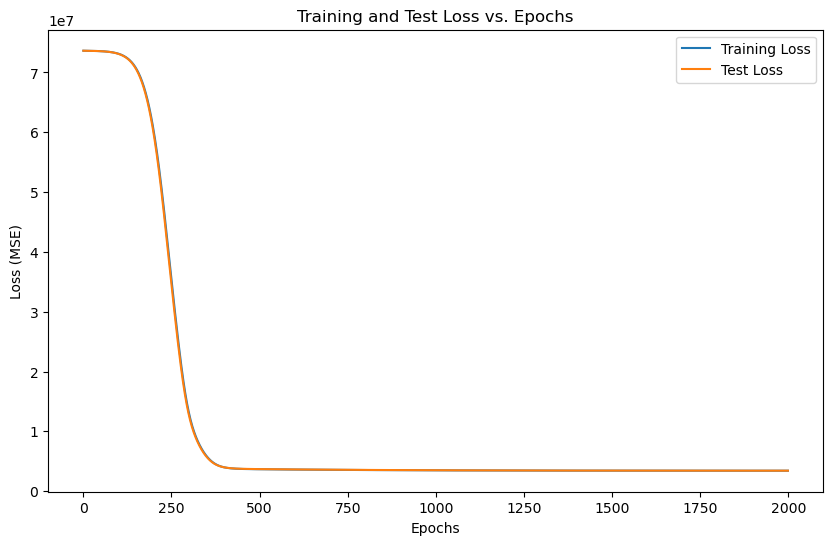

In [541]:
input = [ 'Feed B','Feed S', 'Feed i']
output = ['NGL', 'C1', 'Condensate', 'Sulphur']
hidden_sizes = np.full(5, 5)

fnn, criterion, optimizer = makeNN(input, output, hidden_sizes,df)
models, fold_results, trainLoss, valLoss = trainKfolds(fnn, criterion, optimizer, epochs=2000, n_splits=5)

loss_plot(trainLoss, valLoss)

# Plant Y:
## -------------------------------------------------------------------------

In [ ]:
#importing the data from the excel file and chooses needed data
df_plant_y = pd.read_excel('plants_data.xlsx', sheet_name='Plant Y', usecols='A:M', skiprows=1, nrows=1239)

# df_plant_y.drop(df_plant_y.columns[5], axis=1, inplace=True)
df_plant_y.drop(index=df_plant_y.index[0], inplace=True)

df_plant_y.head()

Date Feed B Feed S Feed k Feed i Feed O  Feed N  C1 RR    C1  NGL RR%  \
1 2021-01-01    299    178     73    797     139    114    1.0  1211     0.95   
2 2021-01-02    299    183     69    758     139    134    1.0  1202     0.95   
3 2021-01-03    299    184     86    769     179    115    1.0  1198     0.95   
4 2021-01-04    299    186     69    749     199    117    1.0  1191     0.95   
5 2021-01-05    299    185     76    667     197    122    1.0  1185     0.95   

     NGL  Sulphur RR% Sulphur  
1   9494          1.0    2658  
2   9687          1.0    2395  
3   9742          1.0    2344  
4  10048          1.0    2409  
5  10053          1.0    2311

In [ ]:
df_plant_y['C1']  = df_plant_y['C1']/df_plant_y['C1 RR']
df_plant_y['NGL']  = df_plant_y['NGL']/df_plant_y['NGL RR']
df_plant_y['Sulphur']  = df_plant_y['Sulphur']/df_plant_y['Sulphur RR']

In [544]:
df_plant_y.head()

Date Feed B Feed S Feed k Feed i Feed O  Feed N  C1 RR      C1  \
1 2021-01-01    299    178     73    797     139    114    1.0  1211.0   
2 2021-01-02    299    183     69    758     139    134    1.0  1202.0   
3 2021-01-03    299    184     86    769     179    115    1.0  1198.0   
4 2021-01-04    299    186     69    749     199    117    1.0  1191.0   
5 2021-01-05    299    185     76    667     197    122    1.0  1185.0   

   NGL RR%           NGL  Sulphur RR% Sulphur  
1     0.95   9993.684211          1.0  2658.0  
2     0.95  10196.842105          1.0  2395.0  
3     0.95  10254.736842          1.0  2344.0  
4     0.95  10576.842105          1.0  2409.0  
5     0.95  10582.105263          1.0  2311.0

In [545]:
# pre-processing the data
NumCols = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N', 'C1', 'NGL', 'Sulphur']
df_y = df_plant_y.copy()
df_y = rm_zeros(df_y,NumCols)
df_y = rm_outliers(df_y, n_neighbors=10, contamination=0.05)
# uni_norm(df_y, NumCols)

In [546]:
df_y= df_y[['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N', 'C1', 'NGL', 'Sulphur']]

In [547]:
df_y = df_y*1.0
val=['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N', 'C1', 'NGL', 'Sulphur']
for i in val:
    df_y[i] = pd.to_numeric(df_y[i], errors='coerce')

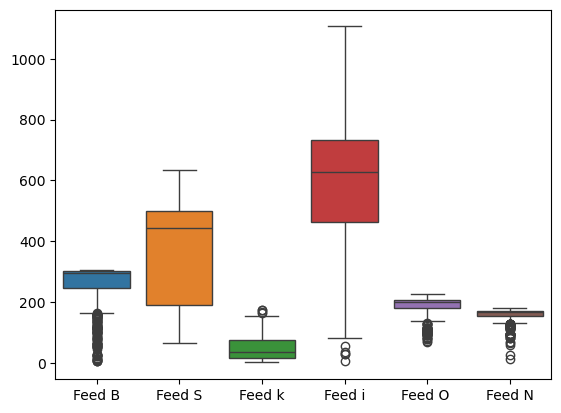

In [548]:
sns.boxplot(data=df_y[['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']])
plt.show()

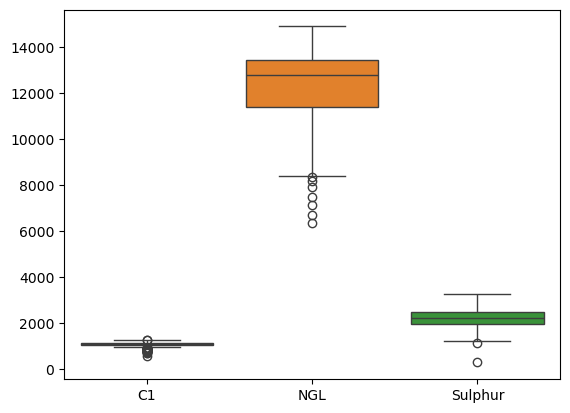

In [549]:
sns.boxplot(data=df_y[['C1', 'NGL', 'Sulphur']])
plt.show()

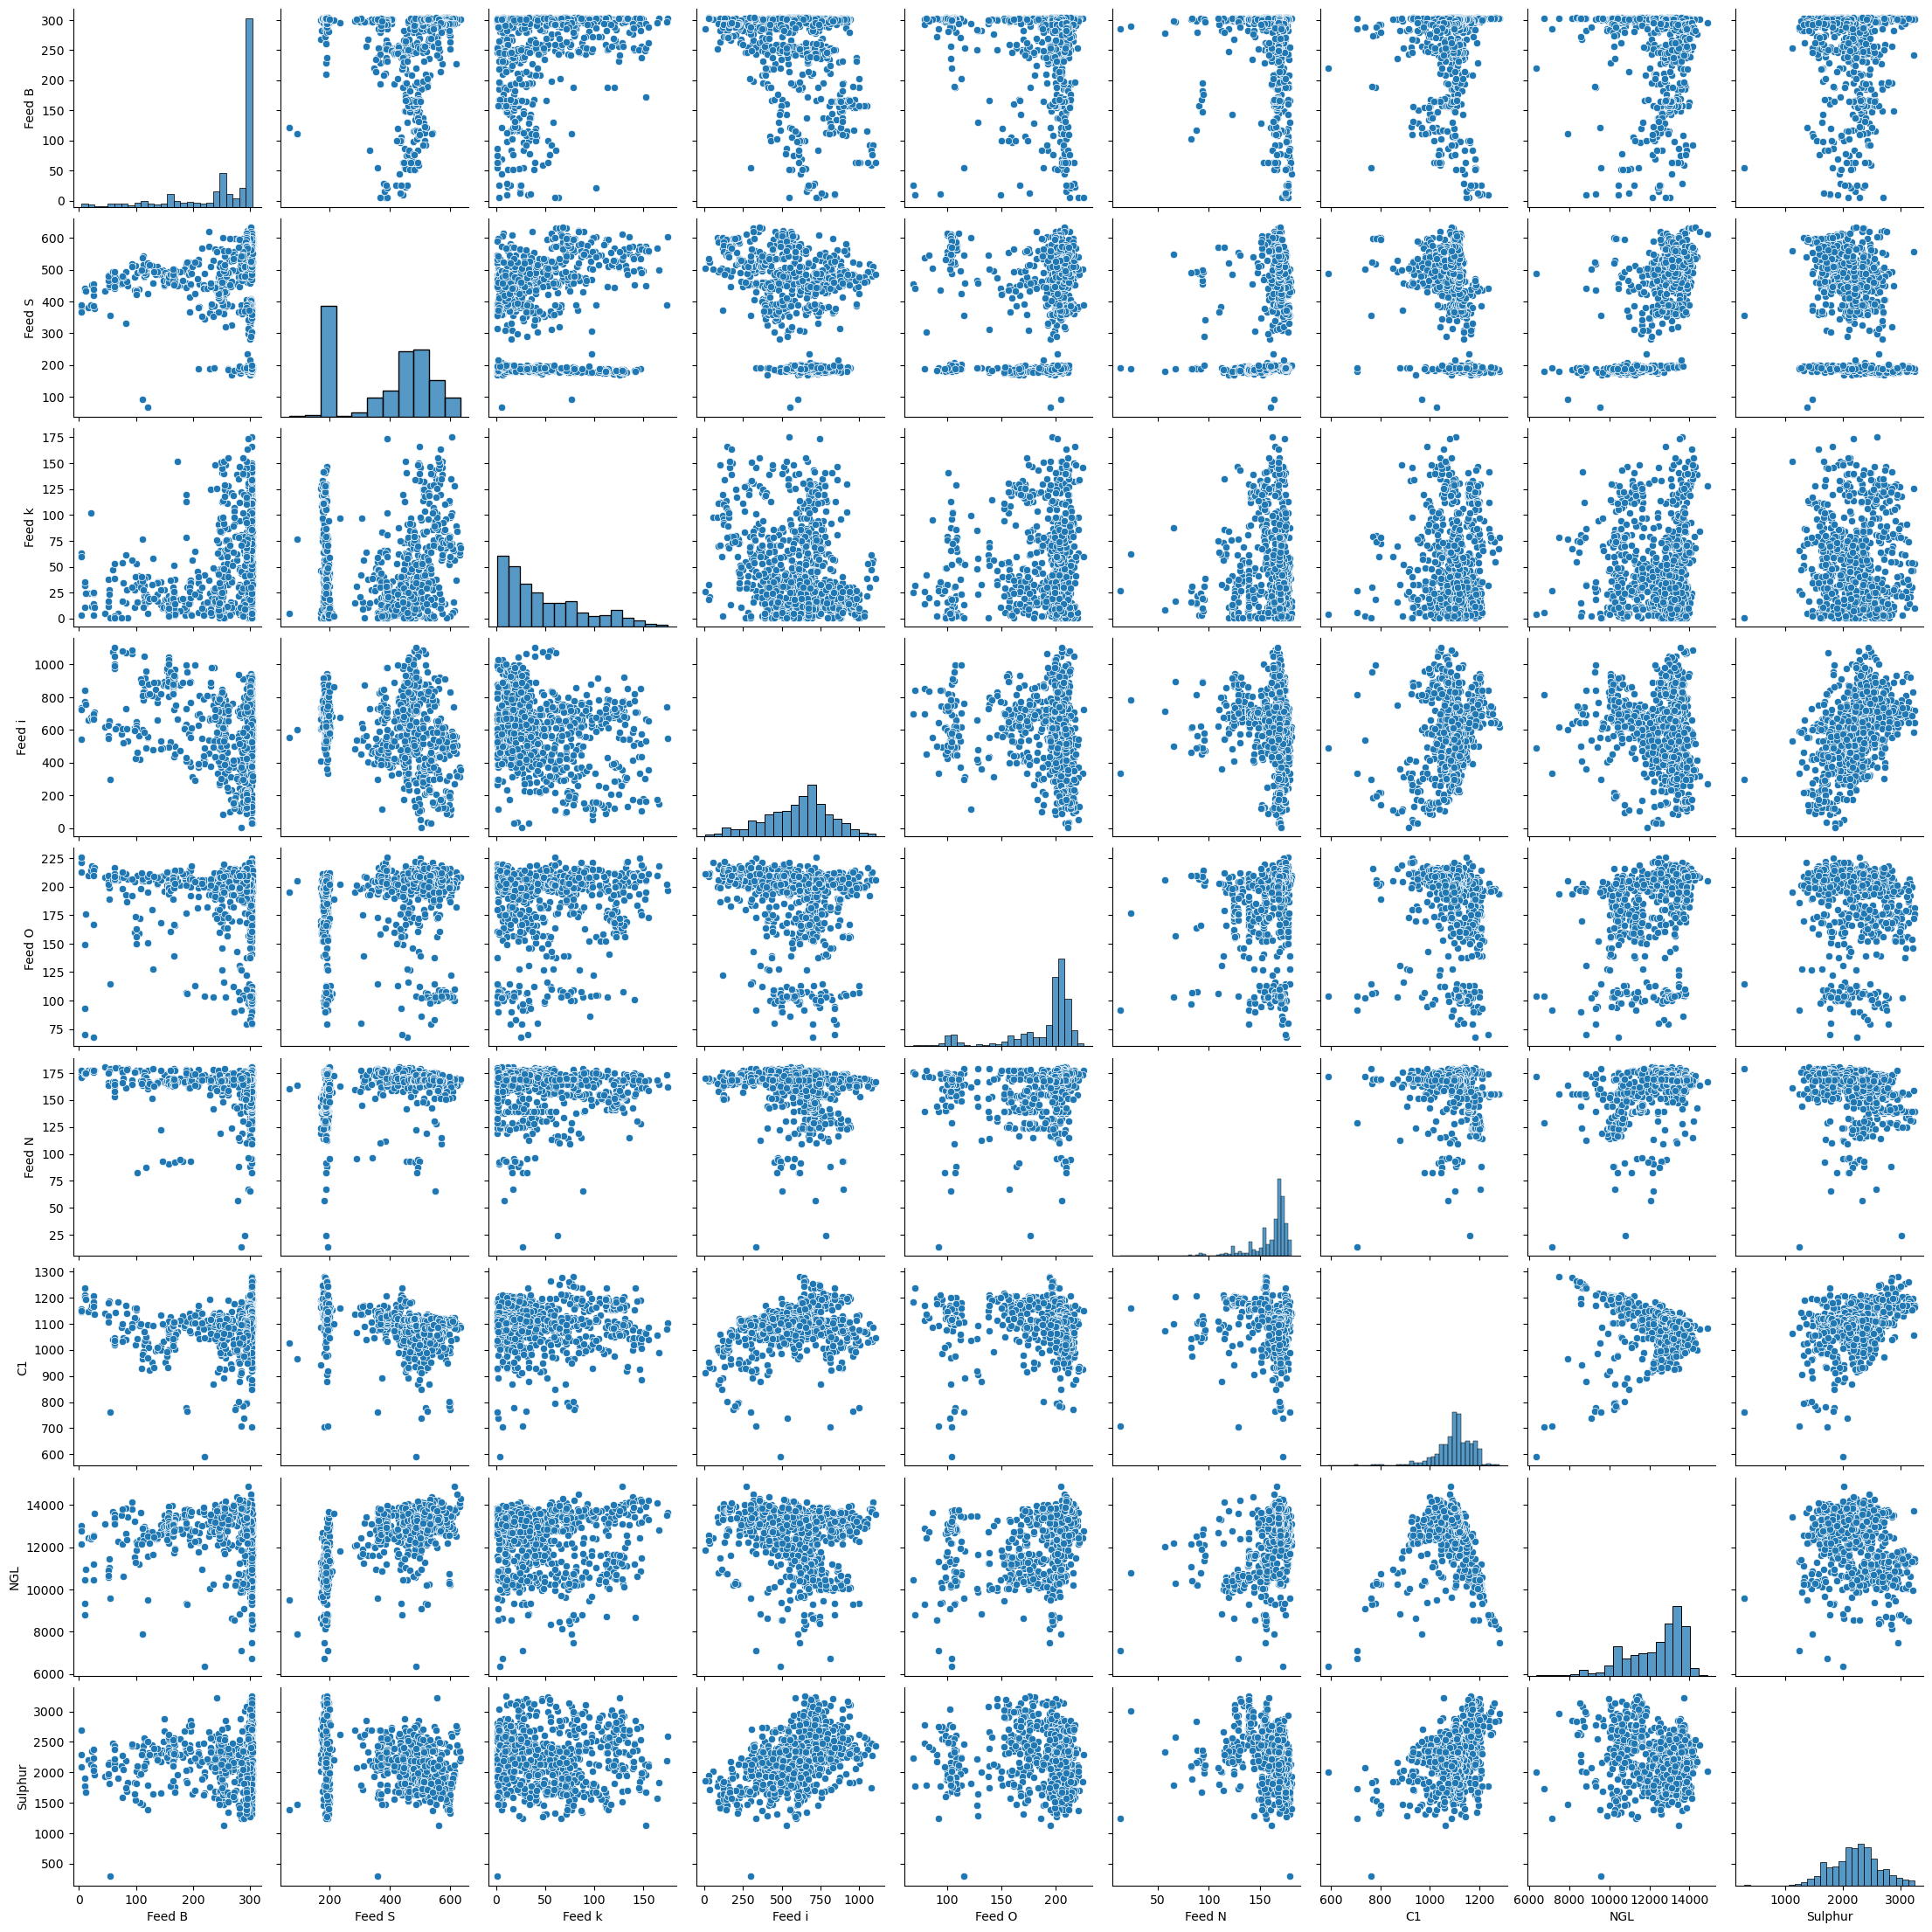

In [550]:
sns.pairplot(df_y)
plt.show()

In [551]:
correlation_matrix = df_y.corr(method='pearson')
print(correlation_matrix)

           Feed B    Feed S    Feed k    Feed i   Feed O     Feed N        C1  \
Feed B   1.000000 -0.312640  0.283547 -0.280069 -0.136985 -0.223631  0.172894   
Feed S  -0.312640  1.000000  0.041892 -0.324894  0.158444  0.449904 -0.497264   
Feed k   0.283547  0.041892  1.000000 -0.227536  0.033745 -0.003462  0.041474   
Feed i  -0.280069 -0.324894 -0.227536  1.000000 -0.116340 -0.197395  0.325478   
Feed O  -0.136985  0.158444  0.033745 -0.116340  1.000000  0.179407 -0.079983   
Feed N  -0.223631  0.449904 -0.003462 -0.197395  0.179407  1.000000 -0.185031   
C1       0.172894 -0.497264  0.041474  0.325478 -0.079983 -0.185031  1.000000   
NGL     -0.134162  0.684594 -0.001057 -0.168623  0.375072  0.463622 -0.225393   
Sulphur  0.115458 -0.347495 -0.010535  0.480912 -0.047323 -0.266559  0.412709   

              NGL   Sulphur  
Feed B  -0.134162  0.115458  
Feed S   0.684594 -0.347495  
Feed k  -0.001057 -0.010535  
Feed i  -0.168623  0.480912  
Feed O   0.375072 -0.047323  
Feed N   

In [552]:
inputs = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
outputs = ['C1', 'NGL', 'Sulphur']
make_graph(df_y,inputs,outputs)

In [553]:
cols = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
C1_models_y , C1_results_y = evaluate_models(df_y,['C1'], cols)
NGL_models_y , NGL_results_y = evaluate_models(df_y,['NGL'], cols)

cols = ['Feed B', 'Feed S','Feed i','Feed O ', 'Feed N']
Sulphur_models_y , Sulphur_results_y = evaluate_models(df_y,['Sulphur'],cols)

===================== Results for =====================
['C1']
                          R2 Score          MSE       RMSE        MAE  \
Linear Regression         0.241330  6713.834163  81.937990  53.143880   
Decision Tree             0.337145  5865.923977  76.589320  41.912281   
Random Forest             0.550044  3981.873813  63.102090  32.364386   
Support Vector Regressor  0.114696  7834.483720  88.512619  53.508432   

                               MAP  
Linear Regression         0.945459  
Decision Tree             0.956700  
Random Forest             0.965602  
Support Vector Regressor  0.943918   

===================== Results for =====================
['NGL']
                          R2 Score           MSE         RMSE          MAE  \
Linear Regression         0.547594  1.010900e+06  1005.435290   682.437121   
Decision Tree             0.691609  6.890984e+05   830.119489   533.185596   
Random Forest             0.759413  5.375906e+05   733.205690   445.219452   
Support 

In [554]:
cols = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
out = ['C1', 'NGL', 'Sulphur']
all_models_y , all_results_y = evaluate_models(df_y,out,cols)

===================== Results for =====================
['C1', 'NGL', 'Sulphur']
                          R2 Score            MSE        RMSE         MAE  \
Linear Regression         0.402799  377322.393320  614.265735  331.390547   
Decision Tree             0.346268  370906.142802  609.020642  310.319278   
Random Forest             0.601343  218871.741955  467.837303  230.365010   
Support Vector Regressor  0.061735  830995.837160  911.589731  486.458536   

                               MAP  
Linear Regression         0.911435  
Decision Tree             0.909774  
Random Forest             0.931605  
Support Vector Regressor  0.883715   




Fold 1/5
Epoch [20/2000], Training Loss: 53112760.0000, Validation Loss: 53028520.0000, MAPE: 0.73%, R²: -1.0114
Epoch [40/2000], Training Loss: 52401812.0000, Validation Loss: 52283252.0000, MAPE: 2.81%, R²: -0.9831
Epoch [60/2000], Training Loss: 51041884.0000, Validation Loss: 50854700.0000, MAPE: 8.02%, R²: -0.9289
Epoch [80/2000], Training Loss: 48462864.0000, Validation Loss: 48181572.0000, MAPE: 19.45%, R²: -0.8275
Epoch [100/2000], Training Loss: 44253760.0000, Validation Loss: 43872112.0000, MAPE: 38.70%, R²: -0.6641
Epoch [120/2000], Training Loss: 38226952.0000, Validation Loss: 37752208.0000, MAPE: 51.09%, R²: -0.4319
Epoch [140/2000], Training Loss: 30698230.0000, Validation Loss: 30171018.0000, MAPE: 54.92%, R²: -0.1444
Epoch [160/2000], Training Loss: 22431076.0000, Validation Loss: 21907072.0000, MAPE: 56.62%, R²: 0.1691
Epoch [180/2000], Training Loss: 14264349.0000, Validation Loss: 13800173.0000, MAPE: 63.55%, R²: 0.4766
Epoch [200/2000], Training Loss: 7387214.5000

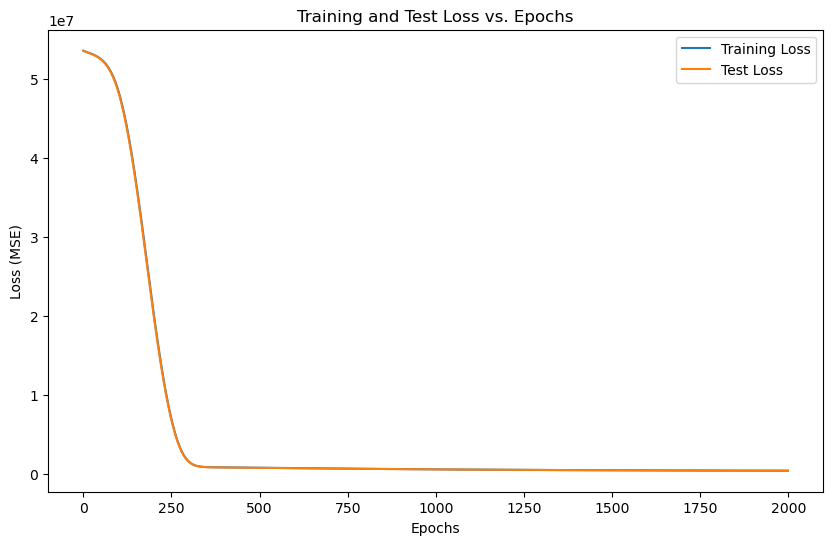

In [555]:
# NOTE: 2^x might be a good idea to set widith at (CNN)
# NOTE: change mape top map
input = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
output = ['C1', 'NGL', 'Sulphur']
hidden_sizes = [16,16]

fnn_y, criterion, optimizer = makeNN(input, output, hidden_sizes,df_y)
models, fold_results, trainLoss, valLoss = trainKfolds(fnn_y, criterion, optimizer, epochs=2000, n_splits=5)

loss_plot(trainLoss, valLoss)

In [556]:
coefficients_y, biases_y = parameter_extractor(all_models_y['Linear Regression'],['C1','NGL', 'Sulphur'])


Fold 1/5
Epoch [20/2000], Training Loss: 47755708.0000, Validation Loss: 47430108.0000, MAPE: 19.43%, R²: -0.7990
Epoch [40/2000], Training Loss: 42126052.0000, Validation Loss: 41653512.0000, MAPE: 28.88%, R²: -0.5799
Epoch [60/2000], Training Loss: 32983794.0000, Validation Loss: 32335484.0000, MAPE: 39.24%, R²: -0.2265
Epoch [80/2000], Training Loss: 21536058.0000, Validation Loss: 20767750.0000, MAPE: 46.02%, R²: 0.2123
Epoch [100/2000], Training Loss: 9559853.0000, Validation Loss: 8919339.0000, MAPE: 72.75%, R²: 0.6617
Epoch [120/2000], Training Loss: 2050771.1250, Validation Loss: 1872528.2500, MAPE: 81.52%, R²: 0.9290
Epoch [140/2000], Training Loss: 344096.0000, Validation Loss: 462816.3750, MAPE: 87.18%, R²: 0.9824
Epoch [160/2000], Training Loss: 348651.0625, Validation Loss: 495948.1562, MAPE: 87.99%, R²: 0.9812
Epoch [180/2000], Training Loss: 327914.1875, Validation Loss: 464671.1250, MAPE: 87.75%, R²: 0.9824
Epoch [200/2000], Training Loss: 326914.9062, Validation Loss:

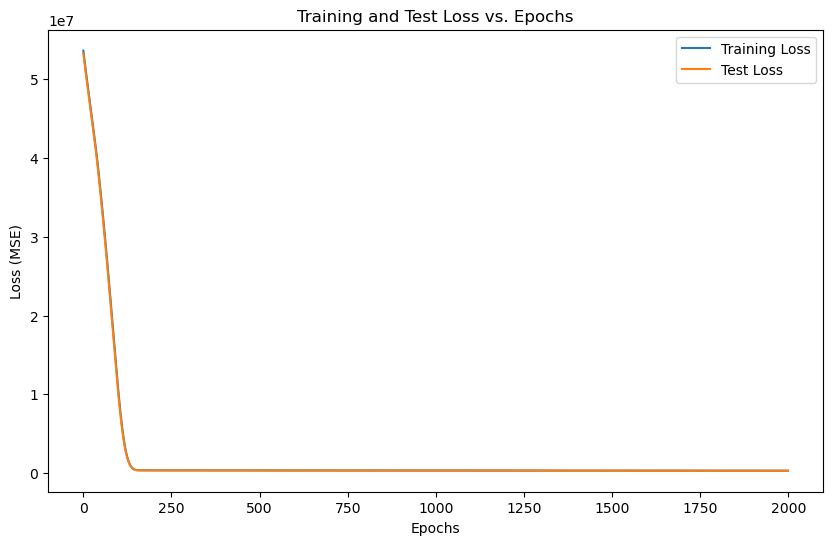

In [557]:
input = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
output = ['C1', 'NGL', 'Sulphur']
hidden_sizes = [3,16,16]

fnn_y, criterion, optimizer = makeNN(input, output, hidden_sizes,df_y,coefficients=coefficients_y , biases=biases_y)
models_s, fold_results_s, trainLoss_S, valLoss_S = trainKfolds(fnn_y, criterion, optimizer, epochs=2000, n_splits=5)

loss_plot(trainLoss_S, valLoss_S)


Fold 1/5
Epoch [20/2000], Training Loss: 53160548.0000, Validation Loss: 53094140.0000, MAPE: 1.05%, R²: -1.0138
Epoch [40/2000], Training Loss: 52414132.0000, Validation Loss: 52318932.0000, MAPE: 2.85%, R²: -0.9844
Epoch [60/2000], Training Loss: 50515292.0000, Validation Loss: 50344776.0000, MAPE: 8.16%, R²: -0.9096
Epoch [80/2000], Training Loss: 46087080.0000, Validation Loss: 45753972.0000, MAPE: 22.56%, R²: -0.7354
Epoch [100/2000], Training Loss: 37499120.0000, Validation Loss: 36956168.0000, MAPE: 53.43%, R²: -0.4017
Epoch [120/2000], Training Loss: 24771078.0000, Validation Loss: 24137458.0000, MAPE: 52.24%, R²: 0.0845
Epoch [140/2000], Training Loss: 10786040.0000, Validation Loss: 10298865.0000, MAPE: 55.27%, R²: 0.6094
Epoch [160/2000], Training Loss: 2191673.7500, Validation Loss: 2278376.5000, MAPE: 74.79%, R²: 0.9136
Epoch [180/2000], Training Loss: 1214778.2500, Validation Loss: 1544940.8750, MAPE: 84.38%, R²: 0.9414
Epoch [200/2000], Training Loss: 1138943.1250, Vali

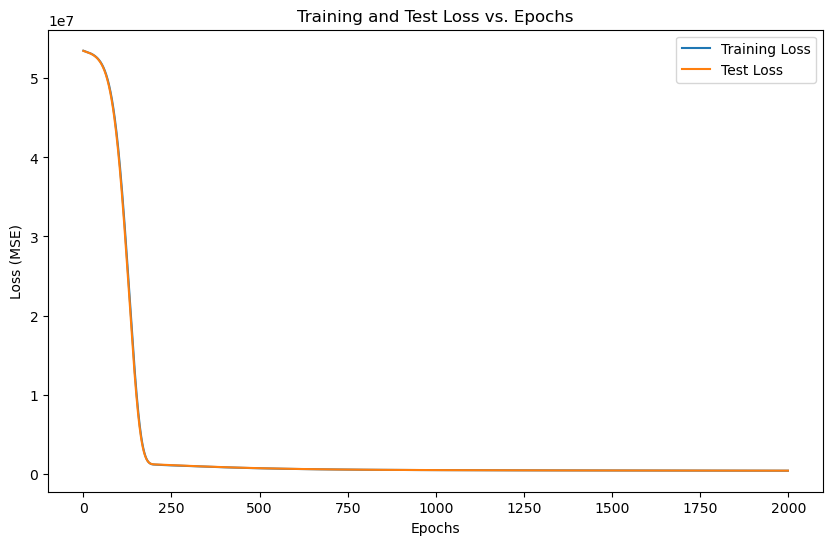

In [558]:
input = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
output = ['C1', 'NGL', 'Sulphur']
hidden_sizes = [16,16,16]

fnn_y, criterion, optimizer = makeNN(input, output, hidden_sizes,df_y)
models_c, fold_results_c, trainLoss_c, valLoss_c = trainKfolds(fnn_y, criterion, optimizer, epochs=2000, n_splits=5)

loss_plot(trainLoss_c, valLoss_c)


Fold 1/5
Epoch [20/2000], Training Loss: 53959108.0000, Validation Loss: 53871488.0000, MAPE: 2.38%, R²: -1.0433
Epoch [40/2000], Training Loss: 53551884.0000, Validation Loss: 53454924.0000, MAPE: 2.76%, R²: -1.0275
Epoch [60/2000], Training Loss: 53053936.0000, Validation Loss: 52942924.0000, MAPE: 3.38%, R²: -1.0081
Epoch [80/2000], Training Loss: 52419060.0000, Validation Loss: 52298928.0000, MAPE: 4.60%, R²: -0.9837
Epoch [100/2000], Training Loss: 51614892.0000, Validation Loss: 51482464.0000, MAPE: 6.85%, R²: -0.9527
Epoch [120/2000], Training Loss: 50551452.0000, Validation Loss: 50406720.0000, MAPE: 10.30%, R²: -0.9119
Epoch [140/2000], Training Loss: 49278140.0000, Validation Loss: 49123692.0000, MAPE: 14.90%, R²: -0.8632
Epoch [160/2000], Training Loss: 47786104.0000, Validation Loss: 47619960.0000, MAPE: 19.98%, R²: -0.8062
Epoch [180/2000], Training Loss: 46048368.0000, Validation Loss: 45872508.0000, MAPE: 26.13%, R²: -0.7399
Epoch [200/2000], Training Loss: 44120260.000

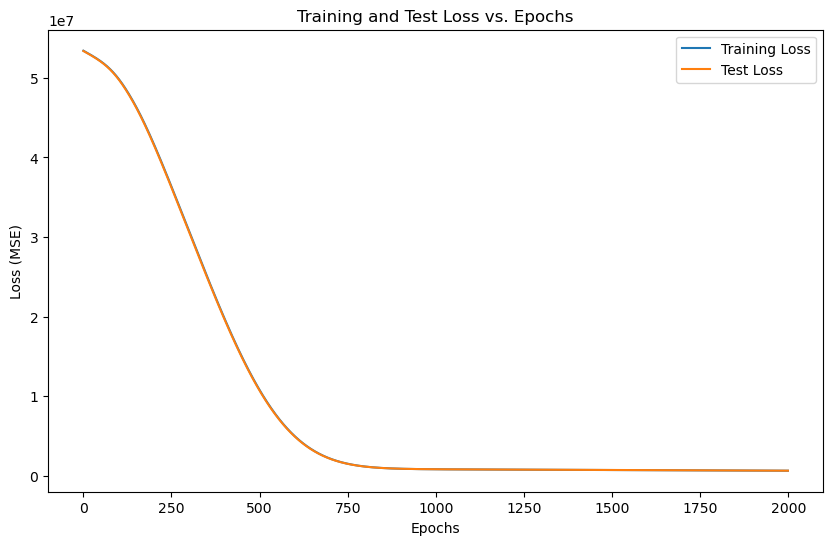

In [559]:
input = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
output = ['C1', 'NGL', 'Sulphur']
hidden_sizes = [16]

fnn_y, criterion, optimizer = makeNN(input, output, hidden_sizes, df_y)
models, fold_results, trainLoss, valLoss = trainKfolds(fnn_y, criterion, optimizer, epochs=2000, n_splits=5)

loss_plot(trainLoss, valLoss)

In [560]:
# NOTE: set the fraction at start maybe
df_y_train = df_y.sample(frac=0.8, random_state=7)
df_y_test = df_y.drop(df_y_train.index)

In [561]:
# TOBEREMOVED
# coefficients_C1, biases_C1 = parameter_extractor(C1_models_y['Linear Regression'],['C1'])
# coefficients_NGL, biases_NGL = parameter_extractor(NGL_models_y['Linear Regression'],['NGL'])
# coefficients_Sulphur, biases_Sulphur = parameter_extractor(Sulphur_models_y['Linear Regression'],['Sulphur'])

In [562]:
input = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
output = ['C1']
hidden_sizes = [16,16]

fnn_y, criterion, optimizer = makeNN(input, output, hidden_sizes,df_y_train)
models_C1, fold_results_C1, trainLoss_C1, valLoss_C1 = trainKfolds(fnn_y, criterion, optimizer, epochs=2000, n_splits=5)


Fold 1/5
Epoch [20/2000], Training Loss: 1005519.0000, Validation Loss: 1032966.6875, MAPE: 8.53%, R²: -187.2389
Epoch [40/2000], Training Loss: 862296.8750, Validation Loss: 888726.4375, MAPE: 15.34%, R²: -160.9538
Epoch [60/2000], Training Loss: 659446.7500, Validation Loss: 682547.9375, MAPE: 26.18%, R²: -123.3816
Epoch [80/2000], Training Loss: 401718.0312, Validation Loss: 417885.0625, MAPE: 43.03%, R²: -75.1518
Epoch [100/2000], Training Loss: 146388.3750, Validation Loss: 154469.0469, MAPE: 67.74%, R²: -27.1491
Epoch [120/2000], Training Loss: 41984.0547, Validation Loss: 42981.3125, MAPE: 83.98%, R²: -6.8325
Epoch [140/2000], Training Loss: 39267.1484, Validation Loss: 35768.2422, MAPE: 85.28%, R²: -5.5181
Epoch [160/2000], Training Loss: 36892.7227, Validation Loss: 35414.2773, MAPE: 85.33%, R²: -5.4536
Epoch [180/2000], Training Loss: 35755.7773, Validation Loss: 34722.1406, MAPE: 85.47%, R²: -5.3275
Epoch [200/2000], Training Loss: 34633.4219, Validation Loss: 33196.0938, M

In [563]:
input = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
output = ['NGL']
hidden_sizes = [16,16]

fnn_y, criterion, optimizer = makeNN(input, output, hidden_sizes,df_y_train)
models_NGL, fold_results_NGL, trainLoss_NGL, valLoss_NGL = trainKfolds(fnn_y, criterion, optimizer, epochs=2000, n_splits=5)


Fold 1/5
Epoch [20/2000], Training Loss: 150063216.0000, Validation Loss: 148938864.0000, MAPE: 1.43%, R²: -88.1711
Epoch [40/2000], Training Loss: 146986512.0000, Validation Loss: 145814080.0000, MAPE: 2.49%, R²: -86.3002
Epoch [60/2000], Training Loss: 142248080.0000, Validation Loss: 140985680.0000, MAPE: 4.16%, R²: -83.4094
Epoch [80/2000], Training Loss: 135025792.0000, Validation Loss: 133641000.0000, MAPE: 6.75%, R²: -79.0121
Epoch [100/2000], Training Loss: 124221264.0000, Validation Loss: 122698568.0000, MAPE: 10.73%, R²: -72.4608
Epoch [120/2000], Training Loss: 108991072.0000, Validation Loss: 107353560.0000, MAPE: 16.63%, R²: -63.2736
Epoch [140/2000], Training Loss: 89491568.0000, Validation Loss: 87807616.0000, MAPE: 24.80%, R²: -51.5712
Epoch [160/2000], Training Loss: 67123768.0000, Validation Loss: 65492380.0000, MAPE: 35.39%, R²: -38.2109
Epoch [180/2000], Training Loss: 44419184.0000, Validation Loss: 42969692.0000, MAPE: 48.22%, R²: -24.7264
Epoch [200/2000], Train

In [564]:
input = ['Feed B', 'Feed S','Feed i','Feed O ', 'Feed N']
output = ['Sulphur']
hidden_sizes = [16,16]

fnn_y, criterion, optimizer = makeNN(input, output, hidden_sizes,df_y_train)
models_Sulphur, fold_result_Sulphur, trainLoss_Sulphur, valLoss_Sulphur = trainKfolds(fnn_y, criterion, optimizer, epochs=2000, n_splits=5)


Fold 1/5
Epoch [20/2000], Training Loss: 5079834.5000, Validation Loss: 5194579.5000, MAPE: 0.65%, R²: -32.4501
Epoch [40/2000], Training Loss: 4779389.5000, Validation Loss: 4897037.0000, MAPE: 3.67%, R²: -30.5341
Epoch [60/2000], Training Loss: 4297271.5000, Validation Loss: 4400398.5000, MAPE: 8.91%, R²: -27.3361
Epoch [80/2000], Training Loss: 3449404.5000, Validation Loss: 3517765.7500, MAPE: 19.03%, R²: -21.6524
Epoch [100/2000], Training Loss: 2225580.0000, Validation Loss: 2266547.2500, MAPE: 36.21%, R²: -13.5953
Epoch [120/2000], Training Loss: 1033972.8750, Validation Loss: 1051070.0000, MAPE: 59.20%, R²: -5.7683
Epoch [140/2000], Training Loss: 352233.2188, Validation Loss: 344214.0625, MAPE: 79.89%, R²: -1.2165
Epoch [160/2000], Training Loss: 220725.0000, Validation Loss: 184555.2656, MAPE: 84.58%, R²: -0.1884
Epoch [180/2000], Training Loss: 217570.5469, Validation Loss: 176878.2344, MAPE: 84.75%, R²: -0.1390
Epoch [200/2000], Training Loss: 211835.7188, Validation Loss:

In [565]:
input = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
output = ['C1', 'NGL', 'Sulphur']
hidden_sizes = [16,16]

fnn_y, criterion, optimizer = makeNN(input, output, hidden_sizes, df_y_train)
models_all, fold_results_all, trainLoss_all, valLoss_all = trainKfolds(fnn_y, criterion, optimizer, epochs=2000, n_splits=5)


Fold 1/5
Epoch [20/2000], Training Loss: 53534880.0000, Validation Loss: 53227072.0000, MAPE: 0.38%, R²: -1.0528
Epoch [40/2000], Training Loss: 53178772.0000, Validation Loss: 52861712.0000, MAPE: 1.57%, R²: -1.0387
Epoch [60/2000], Training Loss: 52573000.0000, Validation Loss: 52243668.0000, MAPE: 3.44%, R²: -1.0149
Epoch [80/2000], Training Loss: 51522700.0000, Validation Loss: 51177084.0000, MAPE: 6.76%, R²: -0.9738
Epoch [100/2000], Training Loss: 49703560.0000, Validation Loss: 49326876.0000, MAPE: 13.26%, R²: -0.9024
Epoch [120/2000], Training Loss: 46713448.0000, Validation Loss: 46292276.0000, MAPE: 24.74%, R²: -0.7854
Epoch [140/2000], Training Loss: 42162464.0000, Validation Loss: 41687484.0000, MAPE: 39.88%, R²: -0.6078
Epoch [160/2000], Training Loss: 36077376.0000, Validation Loss: 35565908.0000, MAPE: 44.60%, R²: -0.3717
Epoch [180/2000], Training Loss: 28819410.0000, Validation Loss: 28301456.0000, MAPE: 53.36%, R²: -0.0915
Epoch [200/2000], Training Loss: 21180874.00

In [566]:
input = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
output = ['C1', 'NGL', 'Sulphur']
y_pred = ensemble_predict(models_all, torch.tensor(df_y_test[input].values, dtype=torch.float32))
y_test = df_y_test[output].to_numpy()

MSE = mean_squared_error(y_test, y_pred)
MAP = 1 - np.mean(np.abs((y_test - y_pred) / y_test))

print(f'MSE: {MSE:.4f}, and MAP: {MAP:.4f}')

MSE: 456601.8957, and MAP: 0.8818


In [567]:
input = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
output = ['C1']
y_pred = ensemble_predict(models_C1, torch.tensor(df_y_test[input].values, dtype=torch.float32))
y_test = df_y_test[output].to_numpy()

MSE = mean_squared_error(y_test, y_pred)
MAP = 1 - np.mean(np.abs((y_test - y_pred) / y_test))

print(f'MSE: {MSE:.4f}, and MAP: {MAP:.4f}')

MSE: 6909.5076, and MAP: 0.9401


In [568]:
input = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
output = ['NGL']
y_pred = ensemble_predict(models_NGL, torch.tensor(df_y_test[input].values, dtype=torch.float32))
y_test = df_y_test[output].to_numpy()

MSE = mean_squared_error(y_test, y_pred)
MAP = 1 - np.mean(np.abs((y_test - y_pred) / y_test))

print(f'MSE: {MSE:.4f}, and MAP: {MAP:.4f}')

MSE: 1079470.1404, and MAP: 0.9331


In [571]:
input = ['Feed B', 'Feed S','Feed i','Feed O ', 'Feed N']
output = ['Sulphur']
y_pred = ensemble_predict(models_Sulphur, torch.tensor(df_y_test[input].values, dtype=torch.float32))
y_test = df_y_test[output].to_numpy()

MSE = mean_squared_error(y_test, y_pred)
MAP = 1 - np.mean(np.abs((y_test - y_pred) / y_test))

print(f'MSE: {MSE:.4f}, and MAP: {MAP:.4f}')

MSE: 134788.9133, and MAP: 0.8618


In [572]:
input = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
output = ['C1', 'NGL', 'Sulphur']
# calculated theoritical yields: 

                    #   C1   NGL Sulphur
yieldsTheo = pd.DataFrame([[0.72, 7.80, 1.55], #B
                      [0.84, 2.00, 2.00], #S
                      [0.70, 9.47, 0.00], #K
                      [0.84, 2.49, 0.90], #i
                      [0.50, 23.4, 1.90], #O
                      [0.80, 6.67, 0.60]], #N
             columns=output, index=inputs) 

In [573]:
# yieldsTheo.head(6)

In [574]:
# fcartion of the entire df_y ins+outs (dataFrame)
# df_y_train
# df_y_test

input = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
output = ['C1', 'NGL', 'Sulphur']
df_y_test_in = df_y_test[input]
df_y_test_out = df_y_test[output]

In [575]:
predTheo = df_y_test_in.dot(yieldsTheo) 
# predTheo.head()

In [576]:
MSE = mean_squared_error(df_y_test_out, predTheo)
MAP = 1 - np.mean(np.abs((df_y_test_out - predTheo) / df_y_test_out))

print(f'MSE: {MSE:.4f}, and MAP: {MAP:.4f}')

MSE: 2379365.9523, and MAP: 0.8266


In [577]:
# NOTE: the model used should not be trained on the fractioned test data, to be changed
cols = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
rows = ['C1', 'NGL', 'Sulphur']
yield_results, yield_std = feedsYield (models_c, cols, rows, multipleModels = 1, constExp = [0,1000,2], feedRangeBounds = [0, 2000])
yield_results = yield_results.T
# NOTE: yileds = 0 sure about it? if yes can we make not fcc
# NOTE: is time series feisable, does output depend on outputs of last day 

In [578]:
yield_results.head(6)

C1        NGL   Sulphur
Feed B   0.820114   9.244093  1.648565
Feed S   0.665724   7.649272  1.354324
Feed k  -0.140777  -1.597598 -0.274590
Feed i   0.263694   2.812596  0.526368
Feed O   1.375461  15.881279  2.817394
Feed N   1.318353  15.224659  2.687000

In [592]:
yield_std.head(6)

Feed B    Feed S    Feed k    Feed i   Feed O     Feed N
C1       0.013680  0.005015  0.068073  0.029575  0.008939  0.022814
NGL      0.183879  0.061004  0.822746  0.326362  0.111590  0.271294
Sulphur  0.034092  0.011119  0.143147  0.057228  0.021468  0.048100

In [579]:
predNN = df_y_test_in.dot(yield_results) 
MSE = mean_squared_error(df_y_test_out, predNN)
MAP = 1 - np.mean(np.abs((df_y_test_out -predNN) / df_y_test_out))

print(f'MSE: {MSE:.4f}, and MAP: {MAP:.4f}')

MSE: 383767.6003, and MAP: 0.8833


In [580]:
cols = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
rows = ['C1']
yield_results_C1, yield_std_C1 = feedsYield (models_C1, cols, rows, multipleModels = 1, constExp = [0,1000,2], feedRangeBounds = [0, 2000])
yield_results_C1 = yield_results_C1.T

In [581]:
cols = ['Feed B', 'Feed S','Feed k','Feed i','Feed O ', 'Feed N']
rows = ['NGL']
yield_results_NGL, yield_std_NGL = feedsYield (models_NGL, cols, rows, multipleModels = 1, constExp = [0,1000,2], feedRangeBounds = [0, 2000])
yield_results_NGL = yield_results_NGL.T

In [582]:
cols = ['Feed B', 'Feed S','Feed i','Feed O ', 'Feed N']
rows = ['Sulphur']
yield_results_Sulphur, yield_std_Sulphur = feedsYield (models_Sulphur, cols, rows, multipleModels = 1, constExp = [0,1000,2], feedRangeBounds = [0, 2000])
yield_results_Sulphur = yield_results_Sulphur.T
yield_results_Sulphur.loc['Feed k'] = 0
yield_std_Sulphur['Feed k'] = -1

In [590]:
yield_new = pd.concat([yield_results_C1, yield_results_NGL, yield_results_Sulphur], axis=1)
yield_new.head(6)

C1        NGL   Sulphur
Feed B   1.158743   9.995194  2.593654
Feed S   0.213407   9.548597  0.362559
Feed k   0.059661   2.348910  0.000000
Feed i   0.474023   3.491616  1.469241
Feed O   1.051817  12.113076  2.040475
Feed N   1.864925   9.944712  1.006755

In [588]:
yield_std_new = pd.concat([yield_std_C1, yield_std_NGL, yield_std_Sulphur], axis=0).T
yield_std_new.head(6)

C1       NGL   Sulphur
Feed B   0.087098  0.000004  0.155134
Feed S   0.076188  0.000475  0.045737
Feed k   0.064237  0.107923 -1.000000
Feed i   0.020185  0.146285  0.010310
Feed O   0.008927  0.000004  0.065699
Feed N   0.019185  0.000004  0.026778

In [594]:
predNN_new = df_y_test_in.dot(yield_new) 
MSE = mean_squared_error(df_y_test_out, predNN_new)
MAP = 1 - np.mean(np.abs((df_y_test_out - predNN_new) / df_y_test_out))

print(f'MSE: {MSE:.4f}, and MAP: {MAP:.4f}')

MSE: 411701.4696, and MAP: 0.9007
